## Time-Periodic Magnetization In Rashba System
### Rashba SOI in square lattice

In [1]:
%%latex
$
H_{\rm tot} = -\sum_{n,m} \left[|n,m\rangle\langle n+1,m|\otimes(t+t_{\rm SO}i\sigma^y)
                              +|n,m\rangle\langle n,m+1|\otimes(t-t_{\rm SO}i\sigma^x)
                               + {\rm h.c.}\right]
$

<IPython.core.display.Latex object>

In the superlattice we construct the local Hamiltonian and the connection matrix between superlattice as follows:

`H[i][i+1]` = $-(t-t_{so}i \sigma_x)$  and

`tau[i][i]` = $-(t+t_{so}i \sigma_y)$


In [2]:
import numpy as np
def sq_rashba_const(mlat,tso):
    """ This function construct The Hamiltonian and the connection
        matrix between superllatice(SL) of a square lattice with mlat 
        sites per SL.
        input:
        -----
        mlat: integer, number of site in SL
        tso: float, in hopping amplitude unit 
            strength of Rashba interation
        
        return:
        -------
        H: mlatxmlat complex matrix, Hamiltonian of the SL
        tau: mlatxmlat complex matrix, connection matrix between SL 
    """
    # Lattice space excluding spin
    h1 = np.zeros((mlat,mlat), dtype=complex)
    tau1 = np.zeros((mlat,mlat), dtype=complex)
    # Lattice space including spin
    h = np.zeros((2*mlat,2*mlat), dtype=complex)
    tau = np.zeros((2*mlat,2*mlat), dtype=complex)
    
    # define the Pauli matrices
    sigmax = np.array([[0,1],
                       [1,0]], dtype=complex)
    sigmay = np.array([[0,-1j],
                       [1j,0]], dtype=complex)
    sigmaz = np.array([[1,0],
                       [0,-1]], dtype=complex)
    sigma0 = np.array([[1,0],
                       [0,1]], dtype=complex)
    
    #loop over all sites in SL
    for i in range(mlat-1):
        h1[i][i+1] =  1.
        tau1[i][i] =  1.
    tau1[mlat-1][mlat-1] = 1.
    # end of loop
    
    # constructing spin including Hamiltonian
    h = np.kron(h1, (-sigma0 + tso*1.j*sigmax))
    tau = np.kron(tau1, -(sigma0 + tso*1.j*sigmay))
    
    # make Hamiltonian Hermitian
    h = h + h.T.conj()
    
    return h, tau

Loop over k points in BZ


In [78]:
import numpy.linalg as lg
N_k = 100
mlat = 2
tso = 0.5
E_data = np.zeros((N_k, 2*mlat), dtype=float)

k_range = np.linspace(-np.pi,np.pi,N_k)
h, tau = sq_rashba_const(mlat, tso)
tau_dag = tau.T.conj()
i = -1
for ka in k_range:
    i+=1
    H_eff = h + np.exp(1.j*ka)*tau + np.exp(-1.j*ka)*tau_dag
    E = lg.eigvalsh(H_eff)
    E_data[i,:] = np.sort(E)
#end of k-loop

[Text(0,0,'$-\\pi$'), Text(0,0,'$0$'), Text(0,0,'$\\pi$')]

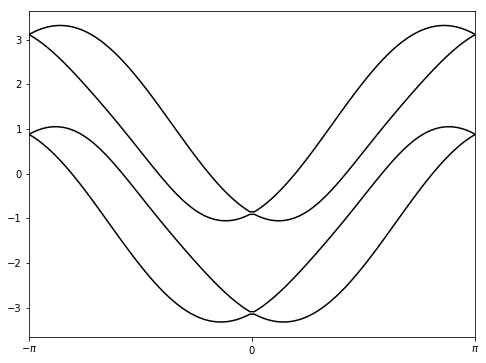

In [79]:
%matplotlib inline
import matplotlib.pyplot as pl
fig, ax = pl.subplots(1,1,figsize=(8,6))
for i in range(2*mlat):
    ax.plot(k_range, E_data[:,i], 'k-')
    
ax.set_xlim(-np.pi,np.pi)
ax.set_xticks((-np.pi,0,np.pi))
ax.set_xticklabels((r'$-\pi$', r'$0$', r'$\pi$'))

### Adding periodic driven field
I assumed that the magnetization is rotating stroboscopically over one
period T. Since it is a square lattice so I prefer to change the magnetization
direction four times per period. It start with direction toward x, then totate
90 degree to align to +y and at the final step it would get back to intial
direction.
Here we write the Hamiltonian constructor in such a way that time also included

In [43]:
import numpy as np
def sq_rashba_const_t(mlat,tso, t_n, mag_st):
    """ This function construct The Hamiltonian and the connection
        matrix between superllatice(SL) of a square lattice with mlat 
        sites per SL. In this version a time-dependent magnetization
        is implemented.
        
        input:
        -----
        mlat: integer, number of site in SL
        tso: float, in hopping amplitude unit 
            strength of Rashba interation
        t_n: integer, time interval, t_N = T, where T
            is one period of driven field
        mag_st: float, magnetization strength
        
        return:
        -------
        H: mlatxmlat complex matrix, Hamiltonian of the SL
        tau: mlatxmlat complex matrix, connection matrix between SL 
    """
    # Lattice space excluding spin
    h1 = np.zeros((mlat,mlat), dtype=complex)
    tau1 = np.zeros((mlat,mlat), dtype=complex)
    # time-dependent magnetization
    h2 = np.zeros((mlat,mlat), dtype=complex)
    # Lattice space including spin
    h = np.zeros((2*mlat,2*mlat), dtype=complex)
    tau = np.zeros((2*mlat,2*mlat), dtype=complex)
    
    # define the Pauli matrices
    sigmax = np.array([[0,1],
                       [1,0]], dtype=complex)
    sigmay = np.array([[0,-1j],
                       [1j,0]], dtype=complex)
    sigmaz = np.array([[1,0],
                       [0,-1]], dtype=complex)
    sigma0 = np.array([[1,0],
                       [0,1]], dtype=complex)
    
    #loop over all sites in SL
    for i in range(mlat-1):
        h1[i][i+1] =  1.
        tau1[i][i] =  1.
    # last site in SL hopping to next SL
    tau1[mlat-1][mlat-1] = 1.
    # end of loop
    
    # constructing spin including Hamiltonian
    h = np.kron(h1, (-sigma0 + tso*1.j*sigmax))
    tau = np.kron(tau1, -(sigma0 + tso*1.j*sigmay))
    
    # time dependent magnetization at each site
    for i in range(mlat):
        h2[i][i] = mag_st
    # time-dependency
    if t_n == 0:
        h += np.kron(h2, sigmax)
    elif t_n == 1:
        h += np.kron(h2, sigmay)
    elif t_n == 2:
        h += np.kron(h2, -sigmax)
    elif t_n == 3:
        h += np.kron(h2, -sigmay)

    # make Hamiltonian Hermitian
    h = h + h.T.conj()
    
    return h, tau

Calculating the Floquet quasienergies:

In [102]:
import numpy.linalg as lg
N_k = 100
N_t = 4
T = 1                    #one period
mlat = 20
mag_st = 0.0
tso = 0.0
E_data = np.zeros((N_k, 2*mlat), dtype=float)

k_range = np.linspace(-np.pi,np.pi,N_k)
ik = -1
for ka in k_range:
    ik+=1
    M_eff = np.eye((2*mlat), dtype=complex)   # aux matrix
    for it in range(N_t):
        h, tau = sq_rashba_const_t(mlat, tso, it, mag_st)
        tau_dag = tau.T.conj()
        H_eff = h + np.exp(1.j*ka)*tau + np.exp(-1.j*ka)*tau_dag
        E_k, U = lg.eig(H_eff)
        U_inv = lg.inv(U)
        # constructing Floquet operator
        M1 = (np.exp((-1.j/4)*E_k*T) * U_inv.T).T                                    
        MM = np.dot(U,M1)
        M_eff = np.dot(M_eff,MM)
    #end of time loop    
    E_Fl = lg.eigvals(M_eff)
    E_real = -np.log(E_Fl).imag
    E_data[ik,:] = np.sort(E_real)
#end of k-loop

[Text(0,0,'$-\\pi$'), Text(0,0,'$0$'), Text(0,0,'$\\pi$')]

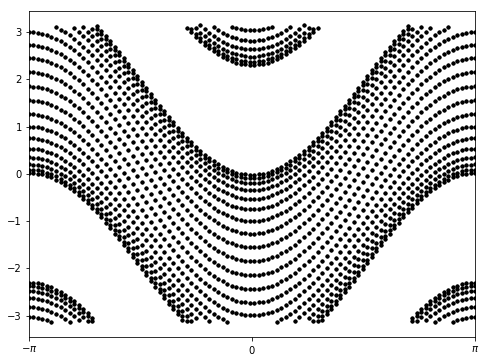

In [104]:
%matplotlib inline
import matplotlib.pyplot as pl
fig, ax = pl.subplots(1,1,figsize=(8,6))
for i in range(2*mlat):
    ax.plot(k_range, E_data[:,i], 'k.')
    
ax.set_xlim(-np.pi,np.pi)
ax.set_xticks((-np.pi,0,np.pi))
ax.set_xticklabels((r'$-\pi$', r'$0$', r'$\pi$'))

My conclution is that lattice must have site A and B per unit cell to have edge state in this 